In [79]:
import argparse
import tensorflow as tf
from tensorflow import keras
from typing import Tuple
import numpy as np
import tensorflow_datasets as tfds
from datetime import datetime
from typing import List
from tensorflow.keras import layers
import logging
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve,confusion_matrix,ConfusionMatrixDisplay;
import matplotlib.pyplot as plt

Epoch 1/10
469/469 [==============================] - 446s 936ms/step - loss: 0.4579 - accuracy: 0.8529 - val_loss: 0.0948 - val_accuracy: 0.9691
Epoch 2/10
469/469 [==============================] - 520s 1s/step - loss: 0.1552 - accuracy: 0.9517 - val_loss: 0.0672 - val_accuracy: 0.9788
Epoch 3/10
469/469 [==============================] - 562s 1s/step - loss: 0.1108 - accuracy: 0.9650 - val_loss: 0.0573 - val_accuracy: 0.9817
Epoch 4/10
469/469 [==============================] - 564s 1s/step - loss: 0.0907 - accuracy: 0.9714 - val_loss: 0.0510 - val_accuracy: 0.9830
Epoch 5/10
469/469 [==============================] - 566s 1s/step - loss: 0.0785 - accuracy: 0.9755 - val_loss: 0.0407 - val_accuracy: 0.9865
Epoch 6/10
469/469 [==============================] - 579s 1s/step - loss: 0.0707 - accuracy: 0.9780 - val_loss: 0.0397 - val_accuracy: 0.9860
Epoch 7/10
469/469 [==============================] - 564s 1s/step - loss: 0.0645 - accuracy: 0.9801 - val_loss: 0.0401 - val_accuracy: 0.9

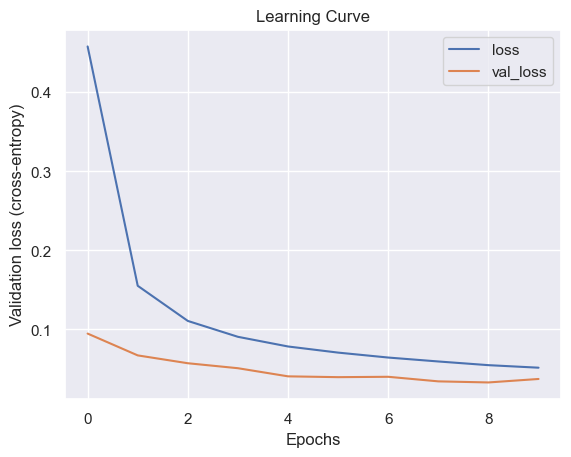

In [80]:


config = {"num_classes": 10,
        "input_shape": [28, 28, 1],
        "learning_rate": 1e-4,
        "weight_decay": 0.0001,
        "batch_size": 64,
        "num_epochs": 10,
        "image_size": 28 , # We'll resize input images to this size
        "patch_size": 7, # Size of the patches to be extract from the input images
        "projection_dim": 256,
        "dropout": 0.2,
        "num_heads": 8,
        "transformer_units": [
            512,
            256,
        ] , # Size of the transformer layers
        "n_transformer_layers": 3,
        "mlp_head_units": [256] ,
          }
config["learning_rate"] = float(config["learning_rate"])
config["input_shape"] = tuple(config["input_shape"])
config["num_patches"] = (config["image_size"] // config["patch_size"]) ** 2
logger = logging.getLogger(__name__)
sns.set_theme()

def mlp(x: tf.Tensor, hidden_units: List[int], dropout_rate: float) -> tf.Tensor:
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def plot_learning_curve(history: tf.keras.callbacks.History, filepath: str):
    history_loss = pd.DataFrame(history.history, columns=["loss", "val_loss"])
    ax = history_loss.plot(xlabel="Epochs", ylabel="Validation loss (cross-entropy)",
                           title="Learning Curve")
    fig = ax.get_figure() # type: ignore
    fig.savefig(filepath)
    
    logger.info("Successfully generated and saved training history figures.")
    return
class Patches(layers.Layer):
    """Create a a set of image patches from input. The patches all have
    a size of patch_size * patch_size.
    """

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    """The `PatchEncoder` layer will linearly transform a patch by projecting it into a
    vector of size `projection_dim`. In addition, it adds a learnable position
    embedding to the projected vector.
    """
    
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


def get_data_augmentation_layer(image_size: int, normalization: bool=True) -> keras.layers.Layer:
    list_layers = []
    
    if normalization:
        list_layers.append(layers.Normalization()) 
    
    list_layers.extend([
            layers.Resizing(image_size, image_size),
            # layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(
                height_factor=0.2, width_factor=0.2
            ),
        ])
    
    data_augmentation = keras.Sequential(
        list_layers,
        name="data_augmentation",
    )
    return data_augmentation

def _normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label 


def load_mnist_dataset(batch_size: int=128, batch: bool=True) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    (ds_train, ds_test), ds_info = tfds.load(
        'mnist',
        split=['train', 'test'],
        shuffle_files=False,
        as_supervised=True,
        with_info=True,
    )
    #(x_train,x_test)=tfds.as_numpy('mnist',split=['train','test'],as_supervised=True)
    dfg=ds_test
    ds_train = ds_train.map(
        _normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
    if batch:
        ds_train = ds_train.batch(128)
        ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    dfg=ds_test
    
    ds_test = ds_test.map(
        _normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    if batch:
        ds_test = ds_test.batch(128)
        ds_test = ds_test.cache()
        ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
    
    return ds_train, ds_test,dfg

def run_experiment(model, ds_train, ds_test,dfg) -> tf.keras.callbacks.History:

    
    optimizer = tf.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    )


    # --- CHECKPOINTS ---
    checkpoint_filepath = "./"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        patience=3,
        monitor="val_loss",
        mode="min",
        restore_best_weights=True
    )
    
    log_dir = datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    
    # --- TRAINING ---
    history = model.fit(
        ds_train,
        epochs=config["num_epochs"],
        validation_data=ds_test,
        callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback],
    )


    # --- EVALUATION ---
    model.load_weights(checkpoint_filepath)
    
    _, accuracy = model.evaluate(ds_test)
    ot=model.predict(ds_test)
    #print(ot)
   # print(ot.shape)
    
    
    
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


    return history,ot,ds_test


def create_vit_classifier(input_shape,
                          num_classes: int,
                          image_size: int,
                          patch_size: int,
                          num_patches: int,
                          projection_dim: int,
                          dropout: float,
                          n_transformer_layers: int,
                          num_heads: int,
                          transformer_units: List[int],
                          mlp_head_units: List[int],
                          normalization: bool=False):
    inputs = layers.Input(shape=input_shape)
    
    # Augment data.
    data_augmentation = get_data_augmentation_layer(image_size=image_size, normalization=normalization)
    augmented = data_augmentation(inputs)
    
    # Create patches.
    patches = Patches(patch_size)(augmented)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(n_transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(dropout)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=dropout)
    
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    
    return model

def main():
    
    # --- Prepare the data ---
    ds_train, ds_test,dfg = load_mnist_dataset(batch_size=config["batch_size"])


    # --- Get model ---
    vit_classifier = create_vit_classifier(input_shape=config["input_shape"],
                                           num_classes=config["num_classes"],
                                           image_size=config["image_size"],
                                           patch_size=config["patch_size"],
                                           num_patches=config["num_patches"],
                                           projection_dim=config["projection_dim"],
                                           dropout=config["dropout"],
                                           n_transformer_layers=config["n_transformer_layers"],
                                           num_heads=config["num_heads"],
                                           transformer_units=config["transformer_units"],
                                           mlp_head_units=config["mlp_head_units"])

    # --- Training ---
    # for i in dfg:
    #     print(np.shape(list(i)))
    #     break
    
        
        
    history,ot,ds_test = run_experiment(vit_classifier, ds_train, ds_test,dfg)
    plot_learning_curve(history=history, filepath="./learning_curve_mnist-VIT.png")
    
    return ot,dfg


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description="Train Vision Transformer Classifier for MNIST.")
ot,dfg=main()


In [81]:
labels=[]
for ex in dfg:
    labels.append(ex[1].numpy())
confusion=np.zeros((10,10)).astype(int)
for i in range (0,1000):
    confusion[labels[i]][np.argmax(ot[i])]+=1


# confusion=confusion_matrix(y_true=labels,y_pred=np.argmax(ot))
print(confusion)
# fpr, tpr, thresholds = roc_curve(labels,ot)
# plot_roc_curve(fpr,tpr)
# plt.savefig('roc-curve.png')
# print(np.argmax(ot[1]),labels[1])

[[108   0   0   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   0   0   0   0]
 [  1   1 110   0   0   0   0   1   0   0]
 [  0   0   0  87   0   0   0   0   0   0]
 [  0   0   0   0  85   0   0   0   0   0]
 [  0   0   0   0   0  89   0   0   0   0]
 [  1   0   0   0   0   0 101   0   1   0]
 [  0   1   0   0   0   0   0 104   0   0]
 [  0   0   1   0   0   0   1   1  95   1]
 [  0   0   0   0   0   0   0   0   1  88]]


In [82]:
cm_df=pd.DataFrame(confusion,index=[i for i in range (0,10)],columns=[i for i in range (0,10)])

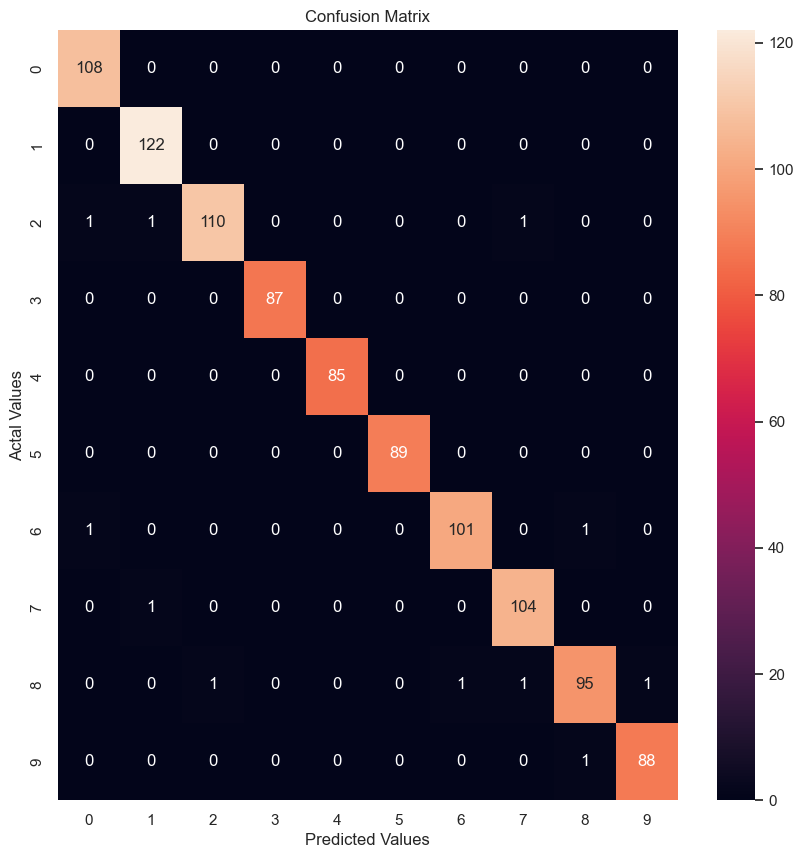

In [83]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_df,annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('confusion_matrix.jpg')
plt.show()


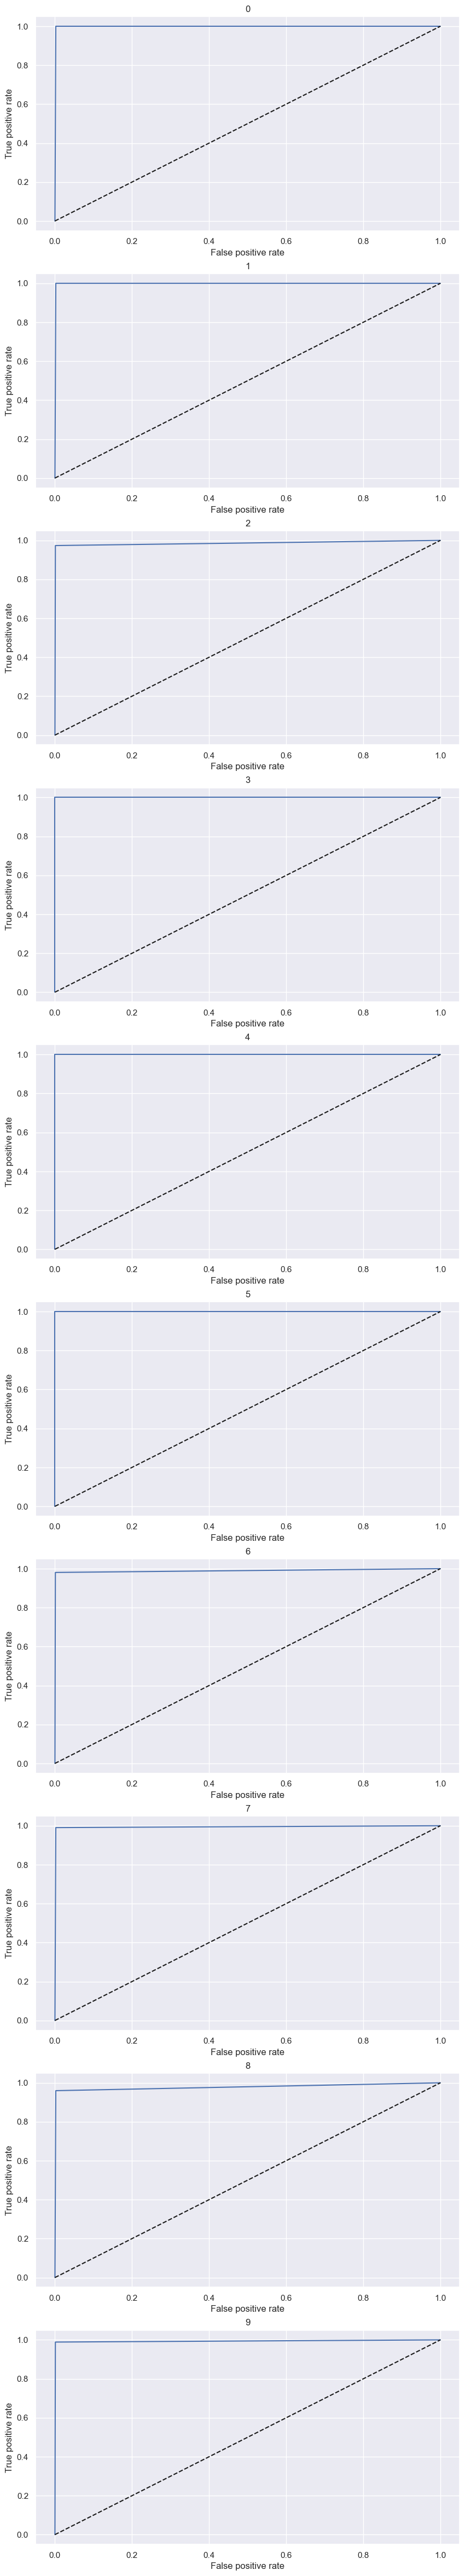

In [84]:
fig,axs=plt.subplots(10,figsize=(10,60))
for i in range(0,10):
    tot=[]
    pot=[]
    for j in range (0,1000):
        if labels[j]==i:
            tot.append(1)
        else:
            tot.append(0)
        if(np.argmax(ot[j])==i):
            pot.append(1)
        else:
            pot.append(0)
    fpr, tpr, thresholds = roc_curve(tot,pot)
   
    
    axs[i].plot(fpr,tpr)
    axs[i].set_title(f"{i}")
    axs[i].plot([0,1],[0,1],"k--")
    axs[i].set_xlabel('False positive rate')
    axs[i].set_ylabel('True positive rate')
    
plt.savefig('roc-curves.png')
plt.show()
